<a href="https://colab.research.google.com/github/Renxs177/hello_-Colaboratory/blob/main/Predicting_Los_Angeles_Traffic_with_Graphical_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Los Angeles Traffic with Graphical Neural Networks
by Julie Wang, Amelia Woodward, Tracy Cai

This notebook accompanies our Medium post on predicting LA Traffic with GNNs. Specifically, it deploys our implementation of the ST-GAT presented by Zhang et al n "Spatial-Temporal Graph Attention Networks: A Deep Learning Approach for Traffic Forecasting".

This code can also be viewed as a github repo in https://github.com/jswang/cs224w_traffic_prediction. 

We will walk through the following steps: 
1.   Installation and Setup
2.   Creating a dataloader
3.   Building the Model
4.   Creating train and evaluation functions
5.   Train the model
6.   Test the model



## Installation and setup

We recommend using a GPU for running our project.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


Install PyTorch, PyG, and other necessary python libraries

In [ ]:
# Install torch geometric
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install wget

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 11.7 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 8.7 MB/s 
     |████████████████████████████████| 325 kB 12.7 MB/s 
     |████████████████████████████████| 407 kB 45.7 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=b4dda1d28d2b58ac7beb9ac612d5cc047638b770b340f025f3439e3302370225
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built torch-geometric
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=2e4daf7d0b36664da147854d5ab12b68c7c5c9776a14d9a6ad580a7da2392735
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02


Mount google for output directories

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd '/content/'
!git clone https://github.com/jswang/stgat_traffic_prediction.git
%cd stgat_traffic_prediction

Mounted at /content/drive
/content
Cloning into 'stgat_traffic_prediction'...
remote: Enumerating objects: 693, done.
remote: Counting objects: 100% (693/693), done.
remote: Compressing objects: 100% (369/369), done.
remote: Total 693 (delta 369), reused 634 (delta 311), pack-reused 0
Receiving objects: 100% (693/693), 22.98 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (369/369), done.
/content/stgat_traffic_prediction


## Creating a Dataloader
Now, we create a dataloader which will process data from `.csv` files into a PyTorch Geometric dataset. 

In [ ]:
import torch
import numpy as np
import pandas as pd
import os
from torch_geometric.data import InMemoryDataset, Data
from shutil import copyfile


def distance_to_weight(W, sigma2=0.1, epsilon=0.5, gat_version=False):
    """"
    Given distances between all nodes, convert into a weight matrix
    :param W distances
    :param sigma2 User configurable parameter to adjust sparsity of matrix
    :param epsilon User configurable parameter to adjust sparsity of matrix
    :param gat_version If true, use 0/1 weights with self loops. Otherwise, use float
    """
    n = W.shape[0]
    W = W / 10000.
    W2, W_mask = W * W, np.ones([n, n]) - np.identity(n)
    # refer to Eq.10
    W = np.exp(-W2 / sigma2) * (np.exp(-W2 / sigma2) >= epsilon) * W_mask

    # If using the gat version of this, round to 0/1 and include self loops
    if gat_version:
        W[W>0] = 1
        W += np.identity(n)

    return W

class TrafficDataset(InMemoryDataset):
    """
    Dataset for Graph Neural Networks.
    """
    def __init__(self, config, W, root='', transform=None, pre_transform=None):
        self.config = config
        self.W = W
        super().__init__(root, transform, pre_transform)
        self.data, self.slices, self.n_node, self.mean, self.std_dev = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [os.path.join(self.raw_dir, 'PeMSD7_V_228.csv')]

    @property
    def processed_file_names(self):
        return ['./data.pt']

    def download(self):
        copyfile('./dataset/PeMSD7_V_228.csv', os.path.join(self.raw_dir, 'PeMSD7_V_228.csv'))

    def process(self):
        """
        Process the raw datasets into saved .pt dataset for later use.
        Note that any self.fields here wont exist if loading straight from the .pt file
        """
        # Data Preprocessing and loading
        data = pd.read_csv(self.raw_file_names[0], header=None).values
        # Technically using the validation and test datasets here, but it's fine, would normally get the
        # mean and std_dev from a large dataset
        mean =  np.mean(data)
        std_dev = np.std(data)
        data = z_score(data, np.mean(data), np.std(data))

        _, n_node = data.shape
        n_window = self.config['N_PRED'] + self.config['N_HIST']

        # manipulate nxn matrix into 2xnum_edges
        edge_index = torch.zeros((2, n_node**2), dtype=torch.long)
        # create an edge_attr matrix with our weights  (num_edges x 1) --> our edge features are dim 1
        edge_attr = torch.zeros((n_node**2, 1))
        num_edges = 0
        for i in range(n_node):
            for j in range(n_node):
                if self.W[i, j] != 0.:
                    edge_index[0, num_edges] = i
                    edge_index[1, num_edges] = j
                    edge_attr[num_edges] = self.W[i, j]
                    num_edges += 1
        # using resize_ to just keep the first num_edges entries
        edge_index = edge_index.resize_(2, num_edges)
        edge_attr = edge_attr.resize_(num_edges, 1)

        sequences = []
        # T x F x N
        for i in range(self.config['N_DAYS']):
            for j in range(self.config['N_SLOT']):
                # for each time point construct a different graph with data object
                # Docs here: https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
                g = Data()
                g.__num_nodes__ = n_node

                g.edge_index = edge_index
                g.edge_attr  = edge_attr

                # (F,N) switched to (N,F)
                sta = i * self.config['N_DAY_SLOT'] + j
                end = sta + n_window
                # [21, 228]
                full_window = np.swapaxes(data[sta:end, :], 0, 1)
                g.x = torch.FloatTensor(full_window[:, 0:self.config['N_HIST']])
                g.y = torch.FloatTensor(full_window[:, self.config['N_HIST']::])
                sequences += [g]

        # Make the actual dataset
        data, slices = self.collate(sequences)
        torch.save((data, slices, n_node, mean, std_dev), self.processed_paths[0])

def get_splits(dataset: TrafficDataset, n_slot, splits):
    """
    Given the data, split it into random subsets of train, val, and test as given by splits
    :param dataset: TrafficDataset object to split
    :param n_slot: Number of possible sliding windows in a day
    :param splits: (train, val, test) ratios
    """
    split_train, split_val, _ = splits
    i = n_slot*split_train
    j = n_slot*split_val
    train = dataset[:i]
    val = dataset[i:i+j]
    test = dataset[i+j:]

    return train, val, test


#Build the Model

Using PyG's built in layers, create a Spatio-Temporal Graph as presented in https://ieeexplore.ieee.org/document/8903252. 

Ths model is a Pytorch model containing an initialization function for setting up the model architecture, and a forward function for performing a forward pass of data through the model.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
class ST_GAT(torch.nn.Module):
    """
    Spatio-Temporal Graph Attention Network as presented in https://ieeexplore.ieee.org/document/8903252
    """
    def __init__(self, in_channels, out_channels, n_nodes, heads=8, dropout=0.0):
        """
        Initialize the ST-GAT model
        :param in_channels Number of input channels
        :param out_channels Number of output channels
        :param n_nodes Number of nodes in the graph
        :param heads Number of attention heads to use in graph
        :param dropout Dropout probability on output of Graph Attention Network
        """
        super(ST_GAT, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes

        self.n_preds = 9
        lstm1_hidden_size = 32
        lstm2_hidden_size = 128

        # single graph attentional layer with 8 attention heads
        self.gat = GATConv(in_channels=in_channels, out_channels=in_channels,
            heads=heads, dropout=0, concat=False)

        # add two LSTM layers
        self.lstm1 = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=lstm1_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.lstm2 = torch.nn.LSTM(input_size=lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)

        # fully-connected neural network
        self.linear = torch.nn.Linear(lstm2_hidden_size, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, data, device):
        """
        Forward pass of the ST-GAT model
        :param data Data to make a pass on
        :param device Device to operate on
        """
        x, edge_index = data.x, data.edge_index
        # apply dropout
        if device == 'cpu':
            x = torch.FloatTensor(x)
        else:
            x = torch.cuda.FloatTensor(x)

        # gat layer: output of gat: [11400, 12]
        x = self.gat(x, edge_index)
        x = F.dropout(x, self.dropout, training=self.training)

        # RNN: 2 LSTM
        # [batchsize*n_nodes, seq_length] -> [batch_size, n_nodes, seq_length]
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        # [12, 50, 228] -> [12, 50, 32]
        x, _ = self.lstm1(x)
        # [12, 50, 32] -> [12, 50, 128]
        x, _ = self.lstm2(x)

        # Output contains h_t for each timestep, only the last one has all input's accounted for
        # [12, 50, 128] -> [50, 128]
        x = torch.squeeze(x[-1, :, :])
        # [50, 128] -> [50, 228*9]
        x = self.linear(x)

        # Now reshape into final output
        s = x.shape
        # [50, 228*9] -> [50, 228, 9]
        x = torch.reshape(x, (s[0], self.n_nodes, self.n_pred))
        # [50, 228, 9] ->  [11400, 9]
        x = torch.reshape(x, (s[0]*self.n_nodes, self.n_pred))
        return x


##Create Train and Evaluation functions

Create a train function which performs a forward and a backward pass using the model.

Create an evaluation function which performs only a forward pass using the model.

These functions will be used in various stages of overall model training and testing.

In [ ]:
@torch.no_grad()
def eval(model, device, dataloader, type=''):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param type Name of evaluation type, e.g. Train/Val/Test
    """
    model.eval()
    model.to(device)

    mae = 0
    rmse = 0
    mape = 0
    n = 0

    # Evaluate model on all data
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch, device)
            truth = batch.y.view(pred.shape)
            if i == 0:
                y_pred = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                y_truth = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
            truth = un_z_score(truth, dataloader.dataset.mean, dataloader.dataset.std_dev)
            pred = un_z_score(pred, dataloader.dataset.mean, dataloader.dataset.std_dev)
            y_pred[i, :pred.shape[0], :] = pred
            y_truth[i, :pred.shape[0], :] = truth
            rmse += RMSE(truth, pred)
            mae += MAE(truth, pred)
            mape += MAPE(truth, pred)
            n += 1
    rmse, mae, mape = rmse / n, mae / n, mape / n

    print(f'{type}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')

    #get the average score for each metric in each batch
    return rmse, mae, mape, y_pred, y_truth

def train(model, device, dataloader, optimizer, loss_fn, epoch):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param optimizer Optimizer to use
    :param loss_fn Loss function
    :param epoch Current epoch
    """
    model.train()
    for _, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}")):
        batch = batch.to(device)
        optimizer.zero_grad()
        y_pred = torch.squeeze(model(batch, device))
        loss = loss_fn()(y_pred.float(), torch.squeeze(batch.y).float())
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()

    return loss

In order to evaluation the performance of the model, we need to define some evaluation metrics.  

*   The Z-score normalizes data using mean and std deviation.
*   MAPE is mean average percentage error. 
*   RMSE is root mean square error.
*   MAE is mean absolute error. 





In [ ]:
def z_score(x, mean, std):
    """
    Z-score normalization function: $z = (X - \mu) / \sigma $,
    where z is the z-score, X is the value of the element,
    $\mu$ is the population mean, and $\sigma$ is the standard deviation.
    :param x: torch array, input array to be normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    :return: torch array, z-score normalized array.
    """
    return (x - mean) / std

def un_z_score(x_normed, mean, std):
    """
    Undo the Z-score calculation
    :param x_normed: torch array, input array to be un-normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    """
    return x_normed * std  + mean


def MAPE(v, v_):
    """
    Mean absolute percentage error, given as a % (e.g. 99 -> 99%)
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAPE averages on all elements of input.
    """
    return torch.mean(torch.abs((v_ - v)) /(v + 1e-15) * 100)


def RMSE(v, v_):
    """
    Mean squared error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, RMSE averages on all elements of input.
    """
    return torch.sqrt(torch.mean((v_ - v) ** 2))


def MAE(v, v_):
    """
    Mean absolute error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAE averages on all elements of input.
    """
    return torch.mean(torch.abs(v_ - v))


Now, let's put it all together. Let's use the `train` and `eval` functions along with the model and dataloadres to create a training function (`model_train`) and testing function (`model_test`).

We also build in tensorboard support for logging of the training metrics over time.


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

# Make a tensorboard writer
writer = SummaryWriter()

def model_train(train_dataloader, val_dataloader, config, device):
    """
    Train the ST-GAT model. Evaluate on validation dataset as you go.
    :param train_dataloader Data loader of training dataset
    :param val_dataloader Dataloader of val dataset
    :param config configuration to use
    :param device Device to evaluate on
    """

    # Make the model. Each datapoint in the graph is 228x12: N x F (N = # nodes, F = time window)
    model = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], dropout=config['DROPOUT'])
    optimizer = optim.Adam(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'])
    loss_fn = torch.nn.MSELoss

    model.to(device)

    # For every epoch, train the model on training dataset. Evaluate model on validation dataset
    for epoch in range(config['EPOCHS']):
        loss = train(model, device, train_dataloader, optimizer, loss_fn, epoch)
        print(f"Loss: {loss:.3f}")
        if epoch % 5 == 0:
            train_mae, train_rmse, train_mape, _, _ = eval(model, device, train_dataloader, 'Train')
            val_mae, val_rmse, val_mape, _, _ = eval(model, device, val_dataloader, 'Valid')
            writer.add_scalar(f"MAE/train", train_mae, epoch)
            writer.add_scalar(f"RMSE/train", train_rmse, epoch)
            writer.add_scalar(f"MAPE/train", train_mape, epoch)
            writer.add_scalar(f"MAE/val", val_mae, epoch)
            writer.add_scalar(f"RMSE/val", val_rmse, epoch)
            writer.add_scalar(f"MAPE/val", val_mape, epoch)

    writer.flush()
    # Save the model
    timestr = time.strftime("%m-%d-%H%M%S")
    torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
            }, os.path.join(config["CHECKPOINT_DIR"], f"model_{timestr}.pt"))

    return model

def model_test(model, test_dataloader, device, config):
    """
    Test the ST-GAT model
    :param test_dataloader Data loader of test dataset
    :param device Device to evaluate on
    """
    _, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')


##Start training

Now with all code in place, let's set up config, load our dataset, and start training!

First, to watch your training over time, load the tensorboard extension

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./runs

此单元格的输出内容太大，只能在登录的情况下显示。


Now, create your dataloaders and start training!

In our default configuration, we train for 60 epochs with a batch size of 50. You can view your training progress in the tensorboard above by clicking the "refresh" button to see new data. Training and validation performance are updated every 5 epochs.

In [ ]:
from torch_geometric.loader import DataLoader

# Constant config to use throughout
config = {
    'BATCH_SIZE': 50,
    'EPOCHS': 60,
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'CHECKPOINT_DIR': './runs',
    'N_PRED': 9,
    'N_HIST': 12,
    'DROPOUT': 0.2,
    # number of possible 5 minute measurements per day
    'N_DAY_SLOT': 288,
    # number of days worth of data in the dataset
    'N_DAYS': 44,
    # If false, use GCN paper weight matrix, if true, use GAT paper weight matrix
    'USE_GAT_WEIGHTS': True,
    'N_NODE': 228,
}
# Number of possible windows in a day
config['N_SLOT']= config['N_DAY_SLOT'] - (config['N_PRED']+config['N_HIST']) + 1

# Load the weight and dataset dataset
distances = pd.read_csv('./dataset/PeMSD7_W_228.csv', header=None).values
W = distance_to_weight(distances, gat_version=config['USE_GAT_WEIGHTS'])
dataset = TrafficDataset(config, W)

# total of 44 days in the dataset, use 34 for training, 5 for val, 5 for test
d_train, d_val, d_test = get_splits(dataset, config['N_SLOT'], (34, 5, 5))
train_dataloader = DataLoader(d_train, batch_size=config['BATCH_SIZE'], shuffle=True)
val_dataloader = DataLoader(d_val, batch_size=config['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(d_test, batch_size=config['BATCH_SIZE'], shuffle=False)

# Get gpu if you can
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

# Configure and train model
config['N_NODE'] = dataset.n_node
model = model_train(train_dataloader, val_dataloader, config, device)

Processing...
Done!


Using cuda


Epoch 0: 100%|██████████| 183/183 [00:06<00:00, 26.16it/s]


Loss: 0.256
Train, MAE: 5.0243940353393555, RMSE: 7.9125165939331055, MAPE: 13.189617156982422
Valid, MAE: 5.053834915161133, RMSE: 7.847815036773682, MAPE: 13.16602611541748


Epoch 1: 100%|██████████| 183/183 [00:04<00:00, 38.19it/s]


Loss: 0.247


Epoch 2: 100%|██████████| 183/183 [00:03<00:00, 45.94it/s]


Loss: 0.356


Epoch 3: 100%|██████████| 183/183 [00:03<00:00, 45.84it/s]


Loss: 0.321


Epoch 4: 100%|██████████| 183/183 [00:03<00:00, 45.78it/s]


Loss: 0.253


Epoch 5: 100%|██████████| 183/183 [00:04<00:00, 45.69it/s]


Loss: 0.236
Train, MAE: 3.7368552684783936, RMSE: 6.391045570373535, MAPE: 9.523011207580566
Valid, MAE: 3.9742846488952637, RMSE: 6.76729154586792, MAPE: 9.99803638458252


Epoch 6: 100%|██████████| 183/183 [00:04<00:00, 45.18it/s]


Loss: 0.213


Epoch 7: 100%|██████████| 183/183 [00:04<00:00, 45.56it/s]


Loss: 0.154


Epoch 8: 100%|██████████| 183/183 [00:04<00:00, 45.31it/s]


Loss: 0.203


Epoch 9: 100%|██████████| 183/183 [00:04<00:00, 45.27it/s]


Loss: 0.126


Epoch 10: 100%|██████████| 183/183 [00:04<00:00, 45.05it/s]


Loss: 0.218
Train, MAE: 3.431297779083252, RMSE: 5.894279479980469, MAPE: 8.705282211303711
Valid, MAE: 3.790898084640503, RMSE: 6.53023624420166, MAPE: 9.536735534667969


Epoch 11: 100%|██████████| 183/183 [00:03<00:00, 46.09it/s]


Loss: 0.149


Epoch 12: 100%|██████████| 183/183 [00:04<00:00, 45.73it/s]


Loss: 0.185


Epoch 13: 100%|██████████| 183/183 [00:03<00:00, 45.90it/s]


Loss: 0.143


Epoch 14: 100%|██████████| 183/183 [00:03<00:00, 46.02it/s]


Loss: 0.166


Epoch 15: 100%|██████████| 183/183 [00:03<00:00, 46.36it/s]


Loss: 0.224
Train, MAE: 3.262099504470825, RMSE: 5.56423807144165, MAPE: 8.141607284545898
Valid, MAE: 3.7339463233947754, RMSE: 6.402459621429443, MAPE: 9.295312881469727


Epoch 16: 100%|██████████| 183/183 [00:03<00:00, 46.21it/s]


Loss: 0.221


Epoch 17: 100%|██████████| 183/183 [00:03<00:00, 45.93it/s]


Loss: 0.175


Epoch 18: 100%|██████████| 183/183 [00:03<00:00, 46.05it/s]


Loss: 0.166


Epoch 19: 100%|██████████| 183/183 [00:03<00:00, 45.90it/s]


Loss: 0.180


Epoch 20: 100%|██████████| 183/183 [00:03<00:00, 46.16it/s]


Loss: 0.211
Train, MAE: 3.1487669944763184, RMSE: 5.3401103019714355, MAPE: 7.7841949462890625
Valid, MAE: 3.733562707901001, RMSE: 6.39630651473999, MAPE: 9.200615882873535


Epoch 21: 100%|██████████| 183/183 [00:03<00:00, 45.94it/s]


Loss: 0.137


Epoch 22: 100%|██████████| 183/183 [00:03<00:00, 45.78it/s]


Loss: 0.141


Epoch 23: 100%|██████████| 183/183 [00:03<00:00, 45.83it/s]


Loss: 0.207


Epoch 24: 100%|██████████| 183/183 [00:03<00:00, 46.41it/s]


Loss: 0.141


Epoch 25: 100%|██████████| 183/183 [00:03<00:00, 46.24it/s]


Loss: 0.125
Train, MAE: 3.0864126682281494, RMSE: 5.18549919128418, MAPE: 7.59406042098999
Valid, MAE: 3.7119662761688232, RMSE: 6.33851957321167, MAPE: 9.20683479309082


Epoch 26: 100%|██████████| 183/183 [00:03<00:00, 46.09it/s]


Loss: 0.129


Epoch 27: 100%|██████████| 183/183 [00:04<00:00, 45.73it/s]


Loss: 0.119


Epoch 28: 100%|██████████| 183/183 [00:03<00:00, 45.80it/s]


Loss: 0.090


Epoch 29: 100%|██████████| 183/183 [00:03<00:00, 45.89it/s]


Loss: 0.136


Epoch 30: 100%|██████████| 183/183 [00:04<00:00, 45.75it/s]


Loss: 0.167
Train, MAE: 3.028179168701172, RMSE: 5.074080944061279, MAPE: 7.4495320320129395
Valid, MAE: 3.6957664489746094, RMSE: 6.333939075469971, MAPE: 9.153971672058105


Epoch 31: 100%|██████████| 183/183 [00:04<00:00, 45.49it/s]


Loss: 0.152


Epoch 32: 100%|██████████| 183/183 [00:04<00:00, 45.54it/s]


Loss: 0.149


Epoch 33: 100%|██████████| 183/183 [00:04<00:00, 45.58it/s]


Loss: 0.163


Epoch 34: 100%|██████████| 183/183 [00:03<00:00, 45.80it/s]


Loss: 0.079


Epoch 35: 100%|██████████| 183/183 [00:04<00:00, 44.97it/s]


Loss: 0.134
Train, MAE: 2.997509717941284, RMSE: 4.9981865882873535, MAPE: 7.287314414978027
Valid, MAE: 3.7374982833862305, RMSE: 6.392979621887207, MAPE: 9.167180061340332


Epoch 36: 100%|██████████| 183/183 [00:03<00:00, 46.20it/s]


Loss: 0.133


Epoch 37: 100%|██████████| 183/183 [00:04<00:00, 45.29it/s]


Loss: 0.134


Epoch 38: 100%|██████████| 183/183 [00:03<00:00, 45.88it/s]


Loss: 0.196


Epoch 39: 100%|██████████| 183/183 [00:03<00:00, 46.00it/s]


Loss: 0.118


Epoch 40: 100%|██████████| 183/183 [00:04<00:00, 45.59it/s]


Loss: 0.121
Train, MAE: 2.9529385566711426, RMSE: 4.916229724884033, MAPE: 7.194719314575195
Valid, MAE: 3.7182185649871826, RMSE: 6.366259574890137, MAPE: 9.16735553741455


Epoch 41: 100%|██████████| 183/183 [00:03<00:00, 46.05it/s]


Loss: 0.143


Epoch 42: 100%|██████████| 183/183 [00:03<00:00, 45.88it/s]


Loss: 0.186


Epoch 43: 100%|██████████| 183/183 [00:03<00:00, 45.89it/s]


Loss: 0.180


Epoch 44: 100%|██████████| 183/183 [00:04<00:00, 45.63it/s]


Loss: 0.137


Epoch 45: 100%|██████████| 183/183 [00:04<00:00, 44.91it/s]


Loss: 0.119
Train, MAE: 2.9275946617126465, RMSE: 4.853134632110596, MAPE: 7.141767501831055
Valid, MAE: 3.740072250366211, RMSE: 6.3743367195129395, MAPE: 9.209250450134277


Epoch 46: 100%|██████████| 183/183 [00:04<00:00, 44.89it/s]


Loss: 0.167


Epoch 47: 100%|██████████| 183/183 [00:04<00:00, 44.22it/s]


Loss: 0.122


Epoch 48: 100%|██████████| 183/183 [00:04<00:00, 45.29it/s]


Loss: 0.103


Epoch 49: 100%|██████████| 183/183 [00:03<00:00, 45.85it/s]


Loss: 0.100


Epoch 50: 100%|██████████| 183/183 [00:04<00:00, 45.19it/s]


Loss: 0.152
Train, MAE: 2.9007420539855957, RMSE: 4.799988269805908, MAPE: 7.050012588500977
Valid, MAE: 3.729079484939575, RMSE: 6.353559970855713, MAPE: 9.162540435791016


Epoch 51: 100%|██████████| 183/183 [00:04<00:00, 45.40it/s]


Loss: 0.126


Epoch 52: 100%|██████████| 183/183 [00:04<00:00, 45.23it/s]


Loss: 0.136


Epoch 53: 100%|██████████| 183/183 [00:04<00:00, 45.43it/s]


Loss: 0.112


Epoch 54: 100%|██████████| 183/183 [00:04<00:00, 45.36it/s]


Loss: 0.145


Epoch 55: 100%|██████████| 183/183 [00:04<00:00, 45.21it/s]


Loss: 0.165
Train, MAE: 2.883657455444336, RMSE: 4.763654708862305, MAPE: 7.03734016418457
Valid, MAE: 3.732534408569336, RMSE: 6.3664703369140625, MAPE: 9.234374046325684


Epoch 56: 100%|██████████| 183/183 [00:04<00:00, 45.13it/s]


Loss: 0.162


Epoch 57: 100%|██████████| 183/183 [00:04<00:00, 45.26it/s]


Loss: 0.128


Epoch 58: 100%|██████████| 183/183 [00:04<00:00, 45.06it/s]


Loss: 0.113


Epoch 59: 100%|██████████| 183/183 [00:04<00:00, 45.18it/s]


Loss: 0.132


## Test the model

Now that we have a trained model, we can test it on the test dataset and visualize its performance

Test, MAE: 3.848196268081665, RMSE: 6.299871921539307, MAPE: 9.210926055908203


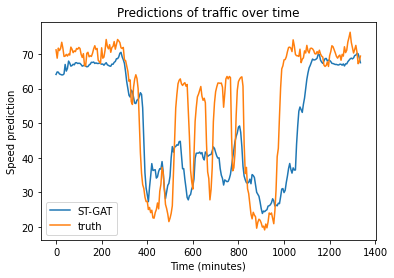

In [ ]:
def plot_prediction(test_dataloader, y_pred, y_truth, node, config):
    # Calculate the truth
    s = y_truth.shape
    y_truth = y_truth.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    # just get the first prediction out for the nth node
    y_truth = y_truth[:, :, node, 0]
    # Flatten to get the predictions for entire test dataset
    y_truth = torch.flatten(y_truth)
    day0_truth = y_truth[:config['N_SLOT']]


    # Calculate the predicted
    s = y_pred.shape
    y_pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    # just get the first prediction out for the nth node
    y_pred = y_pred[:, :, node, 0]
    # Flatten to get the predictions for entire test dataset
    y_pred = torch.flatten(y_pred)
    # Just grab the first day
    day0_pred = y_pred[:config['N_SLOT']]
    t = [t for t in range(0, config['N_SLOT']*5, 5)]
    plt.plot(t, day0_pred, label='ST-GAT')
    plt.plot(t, day0_truth, label='truth')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Speed prediction')
    plt.title('Predictions of traffic over time')
    plt.legend()
    plt.savefig('predicted_times.png')
    plt.show()
    
_, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')
plot_prediction(test_dataloader, y_pred, y_truth, 0, config)

## Rejoice

We hope that you have found this colab informative and useful. Note that our final performance lags that published by the paper slightly, we believe this is due to small differences in training parameters and initializations that were not published with the paper.